# Simple Version of ICP note from niosus's github.

His notebook can be fonund from this url : https://nbviewer.jupyter.org/github/niosus/notebooks/blob/master/icp.ipynb

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown

## Define some functions for plot Handling




In [2]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()

## Generate Lidar Data, Adapt Rotation & Translation to that. 

Thoughout this notebook we will be working wigh generated data that looks like this:

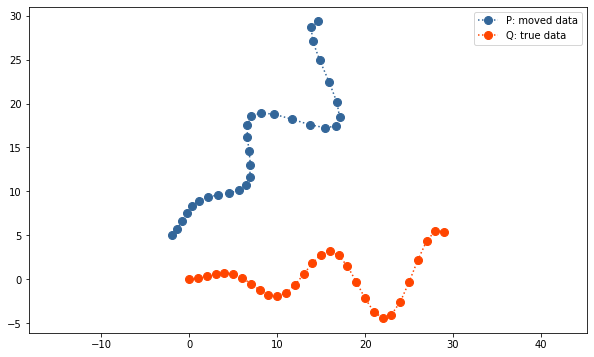

In [3]:
# initialize pertrubation rotation
angle = pi / 4
R_true = np.array([[cos(angle), -sin(angle)], 
                   [sin(angle),  cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

plot_data(moved_data, true_data, "P: moved data", "Q: true data")
plt.show()

## Find Center of Points, then Subtract that From Points

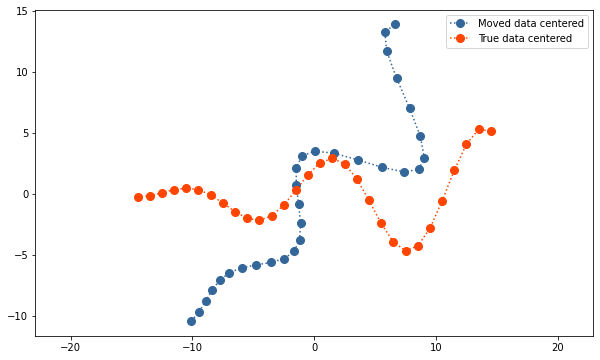

In [4]:
def center_data(data, exclude_indices=[]):    
    reduced_data = np.delete(data, exclude_indices, axis=1)    
    center = np.array([reduced_data.mean(axis=1)]).T    
    return center, data - center

center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

### Correspondences computation, which means closest Point
We compute correspondences from $P$ to $Q$, i.e. for every $p_i$ we search the closest $q_j$ to it.

In [5]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

### Make data centered

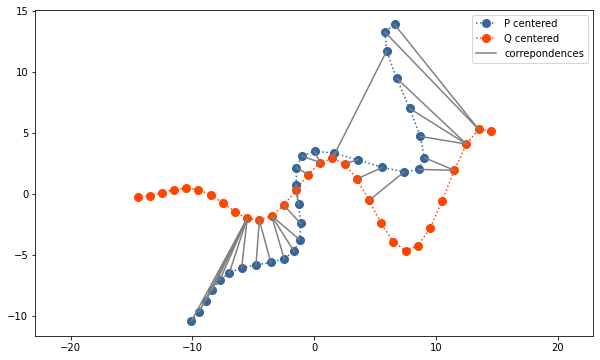

In [6]:
correspondences = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

In [7]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[1113.97274605 1153.71870122]
 [ 367.39948556  478.81890396]]


### Find $R$ and $t$ from SVD decomposition
Here we find SVD decomposition of the cross covariance matrix and apply the rotation to $Q$

* Original Code from Paper

```python
# rotation matrix
H = np.dot(AA.T, BB)
U, S, Vt = np.linalg.svd(H)
R = np.dot(Vt.T, U.T)
```

In [8]:
U, S, V_T = np.linalg.svd(cov)
R_found = U.dot(V_T)
t_found = center_of_Q - R_found.dot(center_of_P)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

R_found =
 [[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]
t_found =
 [[  0.4278782 ]
 [-10.01055887]]


### Apply a single correction to $P$ and visualize the result
This is the result after just one iteration. Because our correspondences are not optimal, it is not a complete match.

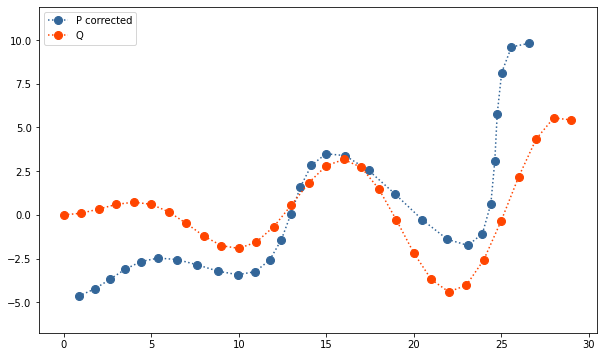

Squared diff: (P_corrected - Q) =  16.052894296516946


In [9]:
P_corrected = R_found.dot(P) + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q')
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

## Let's make it iterative
If we would know the correct correspondences from the start, we would be able to get the optimal solution in a single iteration. This is rarely the case and we need to iterate. That consists of the following steps:
1. Make data centered by subtracting the mean
2. Find correspondences for each point in $P$
3. Perform a single iteration by computing the cross-covariance matrix and performing the SVD
4. Apply the found rotation to $P$
5. Repeat until correspondences don't change
6. Apply the found rotation to the mean vector of $P$ and uncenter $P$ with it.

### Working example
As we want to work with centered data and we will be iteratively centering the data, searching for rotation on centered data and uncentering the data at the end of each iteration. It is not the most elegant or efficient way, but it allows us to visualize the clouds nicer.

In [10]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - R.dot(center_of_P)  
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

## Plotting with Iteration times

### Squared Difference as iteration proceeds

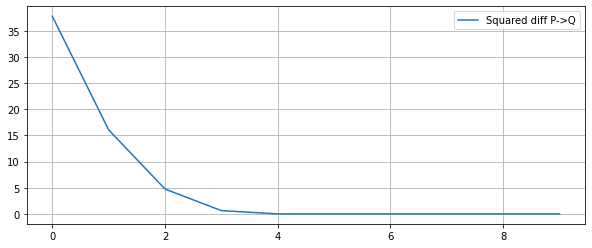

In [11]:
P_values, norm_values, corresp_values = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")


### Final Fiting result 

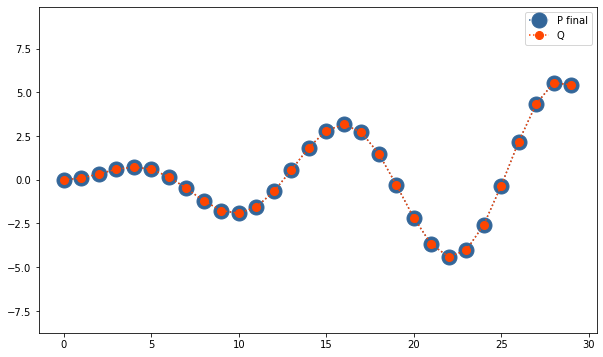

In [12]:
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()


### Final Norm Values

In [13]:
print(norm_values)

[37.7609616179743, 16.052894296516946, 4.747691495229578, 0.6307436032154979, 2.5134508953983984e-14, 2.561305812636684e-14, 3.491311621775616e-14, 3.0614349576571e-14, 4.155981093952672e-14, 3.741243626291695e-14]


##  As mentioned, This Notebook is Simple Version.
### See more in **`icp.ipynb`** !!! 

which contains...

* Non-linear Least-squares based ICP
* Using point to plane metric with Least Squares ICP
* Faster convergence
* Dealing with outliers
